In [1]:
import os
import datetime

# 打印时间
def printbar():
    nowtime = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    print("\n"+"=========="*8 + "%s"%nowtime)

# mac系统上pytorch和matplotlib在jupyter中同时跑需要更改环境变量
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
%matplotlib inline

## 线性回归

### 准备数据

In [3]:
# 生成数据集
n = 400
X = 10 * torch.rand((n, 2)) - 5.0 # (n, 2)
w0 = torch.tensor([[2.0], [-3.0]]) # (2, 1)
b0 = torch.tensor([[10.0]]) # (1, 1)
Y = X @ w0 + b0 + torch.normal(0.0, 2.0, size=(n, 1))

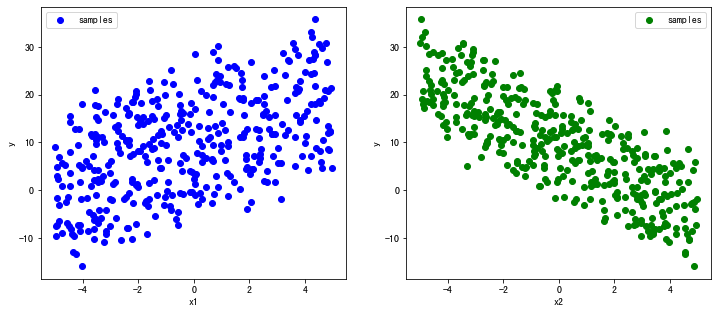

In [4]:
# 可视化
plt.figure(figsize=(12, 5))
ax1 = plt.subplot(121)
ax1.scatter(X[:, 0], Y[:, 0], c='b', label='samples')
ax1.legend()
plt.xlabel('x1')
plt.ylabel('y')

ax2 = plt.subplot(122)
ax2.scatter(X[:, 1], Y[:, 0], c='g', label='samples')
ax2.legend()
plt.xlabel('x2')
plt.ylabel('y')
plt.show()

In [5]:
# 构建输入数据管道
ds = TensorDataset(X, Y)
dl = DataLoader(ds, batch_size=10, shuffle=True, num_workers=2)

### 定义模型

In [6]:
model = nn.Linear(2, 1)

model.loss_func = nn.MSELoss()
model.optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

### 训练模型

In [7]:
def train_step(model, features, labels):
    predictions = model(features) # 正向传播
    loss = model.loss_func(predictions, labels) # 损失
    loss.backward() # 反向传播
    model.optimizer.step() # 更新参数
    model.optimizer.zero_grad() # 梯度清零
    return loss.item()

In [8]:
# 测试train_step效果
features, labels = next(iter(dl))
train_step(model, features, labels)

361.3608093261719

In [9]:
def train_model(model, epochs):
    for epoch in range(1, epochs + 1):
        for features, labels in dl:
            loss = train_step(model, features, labels)
        if epoch % 50 == 0:
            printbar()
            w = model.state_dict()['weight']
            b = model.state_dict()['bias']
            print('epoch = {}, loss = {}'.format(epoch, loss))
            print('w = ', w)
            print('b = ', b)

In [10]:
train_model(model, epochs=200)


================================================================================2021-06-21 20:21:29
epoch = 50, loss = 5.25519323348999
w =  tensor([[ 1.9952, -2.9420]])
b =  tensor([9.9828])

================================================================================2021-06-21 20:22:05
epoch = 100, loss = 5.534440040588379
w =  tensor([[ 2.1055, -2.9197]])
b =  tensor([9.9789])

================================================================================2021-06-21 20:22:39
epoch = 150, loss = 5.758884429931641
w =  tensor([[ 1.9968, -3.0302]])
b =  tensor([9.9575])

================================================================================2021-06-21 20:23:15
epoch = 200, loss = 3.1043920516967773
w =  tensor([[ 2.1391, -2.9627]])
b =  tensor([9.9846])


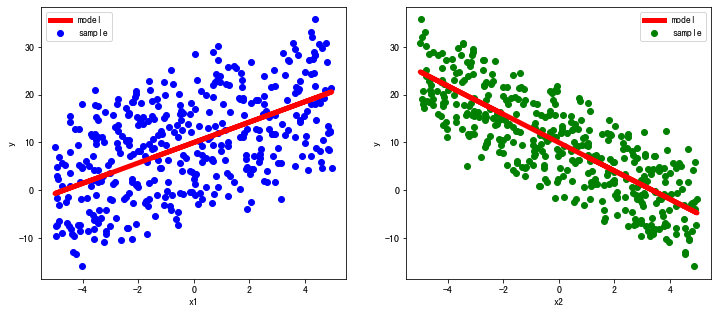

In [11]:
# 结果可视化
w, b = model.state_dict()['weight'], model.state_dict()['bias']

plt.figure(figsize=(12, 5))
ax1 = plt.subplot(121)
ax1.scatter(X[:, 0], Y[:, 0], c='b', label='sample')
ax1.plot(X[:, 0], w[0, 0] * X[:, 0] + b[0], '-r', linewidth=5.0, label='model')
ax1.legend()
plt.xlabel('x1')
plt.ylabel('y')

ax2 = plt.subplot(122)
ax2.scatter(X[:, 1], Y[:, 0], c='g', label='sample')
ax2.plot(X[:, 1], w[0, 1] * X[:, 1] + b[0], '-r', linewidth=5.0, label='model')
ax2.legend()
plt.xlabel('x2')
plt.ylabel('y')
plt.show()

## DNN二分类模型

### 准备数据

In [12]:
# 正负样本数
n_positive, n_negative = 2000, 2000

# 生成正样本, 小圆环分布
r_p = 5.0 + torch.normal(0.0, 1.0, size=(n_positive, 1))
theta_p = 2 * np.pi * torch.rand((n_positive, 1))
# torch.cat() axis=1 沿着列方向拼接
Xp = torch.cat([r_p * torch.cos(theta_p), r_p * torch.sin(theta_p)], axis=1)
Yp = torch.ones_like(r_p)

# 生成负样本, 大圆环分布
r_n = 8.0 + torch.normal(0.0, 1.0, size=(n_negative, 1))
theta_n = 2 * np.pi * torch.rand((n_negative, 1))
Xn = torch.cat([r_n * torch.cos(theta_n), r_n * torch.sin(theta_n)], axis=1)
Yn = torch.zeros_like(r_n)

# 汇总样本
X = torch.cat([Xp, Xn], axis=0) # 沿着行方向拼接
Y = torch.cat([Yp, Yn], axis=0)

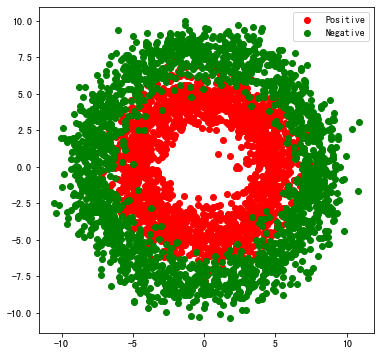

In [13]:
# 可视化
plt.figure(figsize=(6, 6))
plt.scatter(Xp[:, 0], Xp[:, 1], c='r')
plt.scatter(Xn[:, 0], Xn[:, 1], c='g')
plt.legend(['Positive', 'Negative'])
plt.show()

In [14]:
# 构建输入数据管道
ds = TensorDataset(X, Y)
dl = DataLoader(ds, batch_size=10, shuffle=True, num_workers=2)

### 定义模型

In [15]:
class DNNModel(nn.Module):
    def __init__(self):
        super(DNNModel,self).__init__()
        self.fc1 = nn.Linear(2, 4)
        self.fc2 = nn.Linear(4, 8)
        self.fc3 = nn.Linear(8, 1)
        
    # 正向传播
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        y = nn.Sigmoid()(self.fc3(x)) # nn.Sigmoid()(input) 需要这样使用
        return y
    
    # 损失函数
    def loss_func(self, y_pred, y_true):
        return nn.BCELoss()(y_pred, y_true)
    
    # 评估函数(准确率)
    def metric_func(self, y_pred, y_true):
        y_pred = torch.where(
            y_pred > 0.5,
            torch.ones_like(y_pred, dtype=torch.float32),
            torch.zeros_like(y_pred, dtype=torch.float32)
        )
        acc = torch.mean(1 - torch.abs(y_true - y_pred))
        return acc
    
    # 优化器
    @property
    def optimizer(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

In [16]:
model = DNNModel()

In [17]:
features, labels = next(iter(dl))
predictions = model(features)

loss = model.loss_func(predictions, labels)
metric = model.metric_func(predictions, labels)

print('init loss:   ', loss.item())
print('init metric: ', metric.item())

init loss:    0.4709571897983551
init metric:  0.8999999761581421


### 训练模型

In [18]:
def train_step(model, features, labels):
    # 正向传播求损失
    predictions = model(features)
    loss = model.loss_func(predictions, labels)
    metric = model.metric_func(predictions, labels)
    
    # 反向传播求梯度
    loss.backward()
    
    # 更新模型参数
    model.optimizer.step()
    
    # 梯度清零
    model.optimizer.zero_grad()
    
    return loss.item(), metric.item()

In [19]:
# 测试train_step效果
features, labels = next(iter(dl))
train_step(model, features, labels)

(0.9500479698181152, 0.20000000298023224)

In [20]:
def train_model(model, epochs):
    for epoch in range(1, 1 + epochs):
        loss_list, metric_list = [], []
        for features, labels in dl:
            lossi, metrici = train_step(model, features, labels)
            loss_list.append(lossi)
            metric_list.append(metrici)
        loss = np.mean(loss_list)
        metric = np.mean(metric_list)
        
        if epoch % 100 == 0:
            printbar()
            print('epoch = {}, loss = {}, metric = {}'.format(epoch, loss, metric))

In [21]:
train_model(model, epochs=300)


================================================================================2021-06-21 20:25:12
epoch = 100, loss = 0.18906446581269848, metric = 0.9284999932348729

================================================================================2021-06-21 20:27:02
epoch = 200, loss = 0.18953606895636768, metric = 0.9309999923408031

================================================================================2021-06-21 20:28:50
epoch = 300, loss = 0.197888158405367, metric = 0.9314999920129776


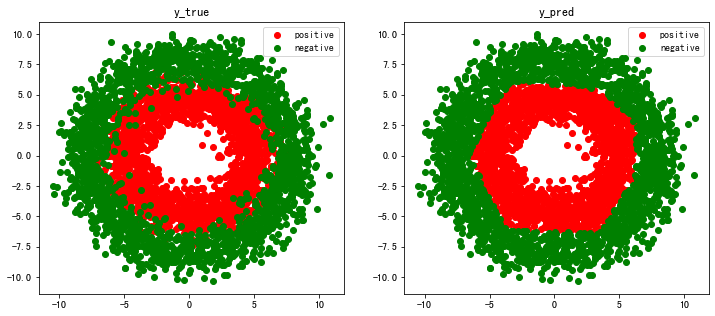

In [22]:
# 结果可视化
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))
ax1.scatter(Xp[:, 0], Xp[:, 1], c="r")
ax1.scatter(Xn[:, 0], Xn[:, 1], c = "g")
ax1.legend(["positive", "negative"])
ax1.set_title("y_true")

Xp_pred = X[torch.squeeze(model.forward(X) >= 0.5)]
Xn_pred = X[torch.squeeze(model.forward(X) < 0.5)]

ax2.scatter(Xp_pred[:, 0],Xp_pred[:, 1],c="r")
ax2.scatter(Xn_pred[:, 0],Xn_pred[:, 1],c="g")
ax2.legend(["positive", "negative"]);
ax2.set_title("y_pred")
plt.show()